In [1]:
import polars as pl

GAME_CAT_COLUMNS = [
    "GAME_CAT"
]

def get_feature_columns(df: pl.DataFrame, prefixes, extra_columns=None):
    """
    Gets all feature columns based on prefixes.
    """
    if extra_columns is None:
        extra_columns = []
    feature_columns = []
    for prefix in prefixes:
        matching_cols = [col for col in df.columns if col.startswith(prefix)]
        feature_columns.extend(matching_cols)
    feature_columns.extend(extra_columns)
    return feature_columns

# Read data
df = pl.read_json("game_data.json")

# Extract category names from column names
columns = get_feature_columns(df, GAME_CAT_COLUMNS)
categories = []
for column in columns:
    categories.append(column.split('GAME_CAT_')[1])

In [2]:
board_game_categories = {
    'time_period_historical': ['ancient', 'medieval', 'renaissance', 'age of reason', 'american west', 'arabian', 'napoleonic', 'post-napoleonic', 'prehistoric'],
    
    'military_conflict': ['world war i', 'world war ii', 'korean war', 'vietnam war', 'modern warfare', 'american revolutionary war', 'american civil war', 'civil war', 'american indian wars', 'pike and shot', 'wargame'],
    
    'based_on_media': ['movies / tv / radio theme', 'video game theme', 'book', 'novel-based', 'comic book / strip', 'music'],
    
    'crime_espionage': ['murder / mystery', 'spies / secret agents', 'mafia'],
    
    'fantasy_supernatural': ['fantasy', 'science fiction', 'mythology', 'zombies', 'pirates'],
    
    'horror': ['horror'],
    
    'resource_management': ['economic', 'industry / manufacturing', 'farming', 'city building', 'civilization', 'territory building'],
    
    'card_game': ['card game'],
    
    'physical_components': ['dice', 'miniatures', 'collectible components'],
    
    'print_and_play': ['print & play'],
    
    'memory': ['memory'],
    
    'trivia': ['trivia'],
    
    'deduction': ['deduction'],
    
    'vehicles_movement': ['aviation / flight', 'trains', 'transportation', 'racing'],
    
    'negotiation': ['negotiation', 'bluffing'],
    
    'mental_skill': ['educational', 'math', 'number', 'word game', 'puzzle'],
    
    'social_entertainment': ['party game', 'children\'s game', 'humor', 'mature / adult'],
    
    'journey_discovery': ['adventure', 'exploration', 'travel', 'maze', 'nautical', 'space exploration'],
    
    'real_world_topics': ['religious', 'political', 'environmental', 'animals'],
    
    'sports': ['sports'],
    
    'fighting': ['fighting'],
    
    'abstract_strategy': ['abstract strategy'],
    
    'real_time': ['real-time'],
    
    'action_dexterity': ['action / dexterity'],
    
    'game_system': ['game system'],

    'electronic' : ['electronic']
}

In [3]:
import polars as pl

# Create new columns for each group category
for group_name in board_game_categories.keys():
    # Create column name with prefix
    group_col_name = f"GAME_CAT_GROUP_{group_name}"
    
    # Get list of categories in this group
    categories_in_group = board_game_categories[group_name]
    
    # Create expression to check if any category in this group is 1
    group_expr = pl.lit(False)
    for category in categories_in_group:
        category_col = f"GAME_CAT_{category}"
        if category_col in df.columns:
            group_expr = group_expr | (pl.col(category_col) == 1)
    
    # Create the new column: 1 if any category in group is 1, otherwise 0
    df = df.with_columns(
        pl.when(group_expr)
        .then(pl.lit(1))
        .otherwise(pl.lit(0))
        .alias(group_col_name)
    )

# Create a list of all original category columns to drop
all_categories = []
for categories_list in board_game_categories.values():
    all_categories.extend(categories_list)

columns_to_drop = [f"GAME_CAT_{category}" for category in all_categories if f"GAME_CAT_{category}" in df.columns]

# Count columns before dropping
num_cols_before = len(df.columns)
num_orig_cats = len(columns_to_drop)

# Drop the original category columns
df = df.drop(columns_to_drop)

# Count columns after dropping
num_cols_after = len(df.columns)
num_group_cols = len(board_game_categories)

# Print statistics
print(f"\nColumn reduction:")
print(f"  • Original category columns dropped: {num_orig_cats}")
print(f"  • New group category columns added: {num_group_cols}")
print(f"  • Total columns before: {num_cols_before}")
print(f"  • Total columns after: {num_cols_after}")
print(f"  • Net reduction: {num_cols_before - num_cols_after} columns")
print(f"  • Space reduction: {(1 - (num_cols_after / num_cols_before)) * 100:.1f}%")

# Verify by counting games in each group
print("\nGame counts by category group:")
for group_name in board_game_categories.keys():
    group_col_name = f"GAME_CAT_GROUP_{group_name}"
    count = df.filter(pl.col(group_col_name) == 1).height
    print(f"  • {group_name}: {count} games")


Column reduction:
  • Original category columns dropped: 81
  • New group category columns added: 26
  • Total columns before: 164
  • Total columns after: 83
  • Net reduction: 81 columns
  • Space reduction: 49.4%

Game counts by category group:
  • time_period_historical: 339 games
  • military_conflict: 632 games
  • based_on_media: 106 games
  • crime_espionage: 37 games
  • fantasy_supernatural: 319 games
  • horror: 33 games
  • resource_management: 244 games
  • card_game: 305 games
  • physical_components: 161 games
  • print_and_play: 26 games
  • memory: 14 games
  • trivia: 12 games
  • deduction: 58 games
  • vehicles_movement: 191 games
  • negotiation: 139 games
  • mental_skill: 67 games
  • social_entertainment: 151 games
  • journey_discovery: 227 games
  • real_world_topics: 146 games
  • sports: 68 games
  • fighting: 122 games
  • abstract_strategy: 144 games
  • real_time: 33 games
  • action_dexterity: 51 games
  • game_system: 5 games
  • electronic: 12 games


In [4]:
RELEVANT_COLUMNS = [
    "AGE_GROUP",
    "GAME_CAT_GROUP",
    "LANGUAGE_DEPENDENCY",
    "GAME_DURATION",
    "GAME_DIFFICULTY"
]

import polars as pl

def get_feature_columns(df: pl.DataFrame, prefixes, extra_columns=None):
    """
    Gets all feature columns based on prefixes.
    """
    if extra_columns is None:
        extra_columns = []
    feature_columns = []
    for prefix in prefixes:
        matching_cols = [col for col in df.columns if col.startswith(prefix)]
        feature_columns.extend(matching_cols)
    feature_columns.extend(extra_columns)
    return feature_columns

# Extract category names from column names
columns = get_feature_columns(df, RELEVANT_COLUMNS)

In [5]:
import polars as pl
import numpy as np
import hdbscan
from typing import List, Dict, Any
from sklearn.manifold import TSNE

RELEVANT_COLUMNS = [
    "AGE_GROUP",
    "GAME_CAT_GROUP",
    "LANGUAGE_DEPENDENCY",
    "GAME_DURATION",
    "GAME_DIFFICULTY"
]

def get_feature_columns(df: pl.DataFrame) -> List[str]:
    """
    Gets all feature columns based on prefixes.
    """
    feature_columns = []
    for prefix in RELEVANT_COLUMNS:
        matching_cols = [col for col in df.columns if col.startswith(prefix)]
        feature_columns.extend(matching_cols)

    return feature_columns


In [6]:
feature_columns = get_feature_columns(df)
feature_df = df.select(feature_columns)

In [7]:
feature_df

AGE_GROUP_adult,AGE_GROUP_kids,AGE_GROUP_teen,AGE_GROUP_family,GAME_CAT_GROUP_time_period_historical,GAME_CAT_GROUP_military_conflict,GAME_CAT_GROUP_based_on_media,GAME_CAT_GROUP_crime_espionage,GAME_CAT_GROUP_fantasy_supernatural,GAME_CAT_GROUP_horror,GAME_CAT_GROUP_resource_management,GAME_CAT_GROUP_card_game,GAME_CAT_GROUP_physical_components,GAME_CAT_GROUP_print_and_play,GAME_CAT_GROUP_memory,GAME_CAT_GROUP_trivia,GAME_CAT_GROUP_deduction,GAME_CAT_GROUP_vehicles_movement,GAME_CAT_GROUP_negotiation,GAME_CAT_GROUP_mental_skill,GAME_CAT_GROUP_social_entertainment,GAME_CAT_GROUP_journey_discovery,GAME_CAT_GROUP_real_world_topics,GAME_CAT_GROUP_sports,GAME_CAT_GROUP_fighting,GAME_CAT_GROUP_abstract_strategy,GAME_CAT_GROUP_real_time,GAME_CAT_GROUP_action_dexterity,GAME_CAT_GROUP_game_system,GAME_CAT_GROUP_electronic,LANGUAGE_DEPENDENCY_high,LANGUAGE_DEPENDENCY_low,LANGUAGE_DEPENDENCY_medium,LANGUAGE_DEPENDENCY_extreme,LANGUAGE_DEPENDENCY_none,GAME_DURATION_long,GAME_DURATION_very_long,GAME_DURATION_short,GAME_DURATION_medium,GAME_DIFFICULTY_easy,GAME_DIFFICULTY_very easy,GAME_DIFFICULTY_medium,GAME_DIFFICULTY_hard,GAME_DIFFICULTY_very hard
i64,i64,i64,i64,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0


Cluster 0: Card Game games characterized by card game, difficulty: easy, language: none, family, duration: medium
Number of games: 305
Sample games: ['Bohnanza', 'Illuminati', 'David & Goliath', 'Mamma Mia!', 'Lost Cities']

Cluster 1: Other games characterized by difficulty: very hard, duration: very long, teen, military conflict, language: medium
Number of games: 65
Sample games: ['Die Macher', 'Magic Realm', 'Federation & Empire', 'Advanced Squad Leader', 'Empires in Arms']

Cluster 2: Other games characterized by family, difficulty: medium, language: none, resource management, duration: long
Number of games: 270
Sample games: ['Tal der Könige', 'Acquire', 'El Caballero', 'Ra', 'CATAN']

Cluster 3: Other games characterized by sports, difficulty: easy, family, kids, vehicles movement
Number of games: 52
Sample games: ['The Really Nasty Horse Racing Game', 'PitchCar', 'Formula Dé', 'Turf Horse Racing', 'TurfMaster']

Cluster 4: Other games characterized by difficulty: easy, social en

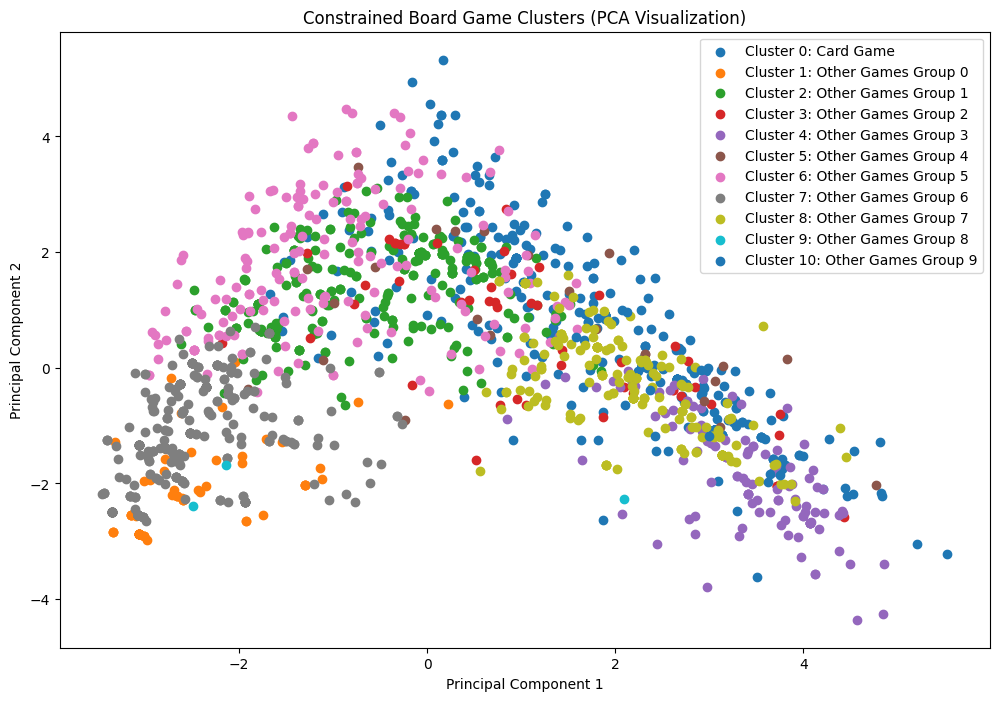

In [8]:
# find the best number of cluster via elbow (visualize)
# clustering for each group of constraints
# PCA + TSNE on visualization
import polars as pl
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

feature_columns = [
    'AGE_GROUP_teen', 'AGE_GROUP_family', 'AGE_GROUP_adult', 'AGE_GROUP_kids', 
    'GAME_CAT_GROUP_time_period_historical', 'GAME_CAT_GROUP_military_conflict', 
    'GAME_CAT_GROUP_based_on_media', 'GAME_CAT_GROUP_crime_espionage', 
    'GAME_CAT_GROUP_fantasy_supernatural', 'GAME_CAT_GROUP_horror', 
    'GAME_CAT_GROUP_resource_management', 'GAME_CAT_GROUP_card_game', 
    'GAME_CAT_GROUP_physical_components', 'GAME_CAT_GROUP_print_and_play', 
    'GAME_CAT_GROUP_memory', 'GAME_CAT_GROUP_trivia', 'GAME_CAT_GROUP_deduction', 
    'GAME_CAT_GROUP_vehicles_movement', 'GAME_CAT_GROUP_negotiation', 
    'GAME_CAT_GROUP_mental_skill', 'GAME_CAT_GROUP_social_entertainment', 
    'GAME_CAT_GROUP_journey_discovery', 'GAME_CAT_GROUP_real_world_topics', 
    'GAME_CAT_GROUP_sports', 'GAME_CAT_GROUP_fighting', 'GAME_CAT_GROUP_abstract_strategy', 
    'GAME_CAT_GROUP_real_time', 'GAME_CAT_GROUP_action_dexterity', 
    'GAME_CAT_GROUP_game_system', 'GAME_CAT_GROUP_electronic', 
    'LANGUAGE_DEPENDENCY_high', 'LANGUAGE_DEPENDENCY_none', 'LANGUAGE_DEPENDENCY_extreme', 
    'LANGUAGE_DEPENDENCY_medium', 'LANGUAGE_DEPENDENCY_low', 'GAME_DURATION_very_long', 
    'GAME_DURATION_medium', 'GAME_DURATION_short', 'GAME_DURATION_long', 
    'GAME_DIFFICULTY_very hard', 'GAME_DIFFICULTY_very easy', 'GAME_DIFFICULTY_medium', 
    'GAME_DIFFICULTY_easy', 'GAME_DIFFICULTY_hard'
]

class ConstrainedBoardGameRecommender:
    def __init__(self):
        self.scaler = StandardScaler()
        self.games_df = None
        self.feature_data = None
        self.cluster_descriptions = None
        self.id_column = None
        self.name_column = None
        self.constraint_columns = []
        self.clusters = {}
        
    def fit(self, games_df, constraint_columns, id_column=None, name_column=None):
        """
        Fit the model with constrained clustering.
        
        Parameters:
        -----------
        games_df : polars.DataFrame
            DataFrame containing board game features
        constraint_columns : list
            List of column names that will be used to force clustering
            Example: ['GAME_CAT_GROUP_card_game', 'GAME_CAT_GROUP_abstract_strategy']
        id_column : str, optional
            Name of the column containing game IDs
        name_column : str, optional
            Name of the column containing game names
        """
        self.games_df = games_df.clone()
        self.id_column = id_column
        self.name_column = name_column
        self.constraint_columns = constraint_columns
        
        # Extract feature data
        self.feature_data = games_df.select(feature_columns).to_numpy()
        
        # Scale the data for future similarity calculations
        self.scaler.fit(self.feature_data)
        
        # Create constrained clusters
        self._create_constrained_clusters()
        
        # Add cluster labels to the DataFrame
        self._add_cluster_labels()
        
        # Generate cluster descriptions
        self.generate_cluster_descriptions()
        
        return self
    
    def _create_constrained_clusters(self):
        """Create clusters based on constraint columns"""
        self.clusters = {}
        cluster_id = 0
        
        # For each constraint column, create a dedicated cluster 
        # for games that have a positive value for that column
        
        # First, handle the explicitly constrained clusters
        for constraint in self.constraint_columns:
            if constraint not in self.games_df.columns:
                print(f"Warning: Constraint column '{constraint}' not found in the data")
                continue
                
            # Get games that match this constraint
            matching_games = self.games_df.filter(pl.col(constraint) == 1)
            
            if matching_games.height > 0:
                # Get the indices of matching games
                mask = (self.games_df[constraint] == 1).to_list()
                indices = [i for i, matches in enumerate(mask) if matches]
                
                self.clusters[cluster_id] = {
                    'constraint': constraint,
                    'indices': indices,
                    'count': matching_games.height
                }
                cluster_id += 1
        
        # Then create a "leftover" cluster for games that don't match any constraints
        assigned_indices = set()
        for cluster_info in self.clusters.values():
            assigned_indices.update(cluster_info['indices'])
        
        remaining_indices = set(range(self.games_df.height)) - assigned_indices
        
        if remaining_indices:
            # For remaining games, use standard K-means to further segment them
            if len(remaining_indices) > 20:  # Only cluster if we have enough samples
                # Extract features for unassigned games
                remaining_features = self.feature_data[list(remaining_indices)]
                
                # Scale the features
                scaled_features = self.scaler.transform(remaining_features)
                
                # Determine number of sub-clusters based on dataset size
                n_subclusters = max(2, min(10, len(remaining_indices) // 10))
                
                # Apply K-means
                kmeans = KMeans(n_clusters=n_subclusters, random_state=42, n_init=10)
                sub_labels = kmeans.fit_predict(scaled_features)
                
                # Create clusters for each sub-group
                for sub_id in range(n_subclusters):
                    sub_indices = [idx for i, idx in enumerate(remaining_indices) 
                                if sub_labels[i] == sub_id]
                    
                    if sub_indices:
                        self.clusters[cluster_id] = {
                            'constraint': 'other_games_group_' + str(sub_id),
                            'indices': sub_indices,
                            'count': len(sub_indices)
                        }
                        cluster_id += 1
            else:
                # If too few games, just create one "other" cluster
                self.clusters[cluster_id] = {
                    'constraint': 'other_games',
                    'indices': list(remaining_indices),
                    'count': len(remaining_indices)
                }
                cluster_id += 1
    
    def _add_cluster_labels(self):
        """Add cluster labels to the DataFrame"""
        # Initialize all cluster labels to -1
        cluster_labels = [-1] * self.games_df.height
        
        # Assign cluster labels
        for cluster_id, cluster_info in self.clusters.items():
            for idx in cluster_info['indices']:
                cluster_labels[idx] = cluster_id
        
        # Add to DataFrame
        self.games_df = self.games_df.with_columns(
            pl.Series("cluster", cluster_labels)
        )
    
    def generate_cluster_descriptions(self):
        """Generate descriptions for each cluster based on feature importance"""
        self.cluster_descriptions = {}
        
        for cluster_id, cluster_info in self.clusters.items():
            # Get games in this cluster
            cluster_games = self.games_df.filter(pl.col("cluster") == cluster_id)
            
            if cluster_games.height == 0:
                continue
                
            # Calculate average feature values for this cluster
            cluster_means = {}
            for feature in feature_columns:
                cluster_means[feature] = cluster_games.select(pl.col(feature)).mean().item()
            
            # Find the most important features (highest average values)
            sorted_features = sorted(cluster_means.items(), key=lambda x: x[1], reverse=True)
            top_features = [feature for feature, _ in sorted_features[:5]]
            
            # Create a description
            constraint_name = cluster_info['constraint'].replace("GAME_CAT_GROUP_", "").replace("_", " ")
            
            if any(constraint in cluster_info['constraint'] for constraint in self.constraint_columns):
                description = f"Cluster {cluster_id}: {constraint_name.title()} games characterized by "
            else:
                description = f"Cluster {cluster_id}: Other games characterized by "
                
            description += ", ".join([
                f.replace("GAME_CAT_GROUP_", "").replace("AGE_GROUP_", "")
                .replace("LANGUAGE_DEPENDENCY_", "language: ")
                .replace("GAME_DURATION_", "duration: ")
                .replace("GAME_DIFFICULTY_", "difficulty: ")
                .replace("_", " ") 
                for f in top_features
            ])
            
            # Get sample games
            if self.name_column:
                sample_games = cluster_games.select(pl.col(self.name_column)).to_series().to_list()[:5]
            elif self.id_column:
                sample_games = cluster_games.select(pl.col(self.id_column)).to_series().to_list()[:5]
            else:
                sample_games = [f"Game #{i}" for i in range(min(5, cluster_games.height))]
            
            self.cluster_descriptions[cluster_id] = {
                'description': description,
                'constraint': cluster_info['constraint'],
                'top_features': top_features,
                'count': cluster_games.height,
                'sample_games': sample_games
            }
        
        return self.cluster_descriptions
    
    def visualize_clusters(self):
        """Visualize clusters using PCA to reduce dimensionality to 2D"""
        # Scale the features
        scaled_features = self.scaler.transform(self.feature_data)
        
        # Apply PCA to reduce to 2 dimensions for visualization
        pca = PCA(n_components=2)
        reduced_features = pca.fit_transform(scaled_features)
        
        # Get cluster labels
        cluster_labels = self.games_df.select("cluster").to_series().to_list()
        
        # Create a plot
        plt.figure(figsize=(12, 8))
        
        for cluster_id in self.clusters.keys():
            # Get points for this cluster
            cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
            cluster_points = reduced_features[cluster_indices]
            
            if len(cluster_points) > 0:
                # Get constraint name for the legend
                constraint = self.clusters[cluster_id]['constraint']
                constraint_name = constraint.replace("GAME_CAT_GROUP_", "").replace("_", " ").title()
                
                plt.scatter(
                    cluster_points[:, 0], 
                    cluster_points[:, 1], 
                    label=f'Cluster {cluster_id}: {constraint_name}'
                )
        
        plt.title('Constrained Board Game Clusters (PCA Visualization)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.show()
    
    def get_cluster_info(self, cluster_id):
        """Get information about a specific cluster"""
        if cluster_id not in self.cluster_descriptions:
            return f"Cluster {cluster_id} not found"
        
        info = self.cluster_descriptions[cluster_id]
        return info
    
    def get_all_clusters_info(self):
        """Get information about all clusters"""
        return self.cluster_descriptions

# Example usage:
# Assuming you already have a Polars DataFrame called 'df'
recommender = ConstrainedBoardGameRecommender()

# Define constraint columns - games with these features will be forced into separate clusters
constraint_columns = ['GAME_CAT_GROUP_card_game']

# Fit the model
recommender.fit(
    df, 
    constraint_columns=constraint_columns,
    id_column="game_id", 
    name_column="game_name"
)

# Print cluster information
for cluster_id, info in recommender.get_all_clusters_info().items():
    print(info['description'])
    print(f"Number of games: {info['count']}")
    print(f"Sample games: {info['sample_games']}")
    print()

recommender.visualize_clusters()

Finding optimal subclusters for GAME_CAT_GROUP_card_game...
Finding optimal clusters for unconstrained games...


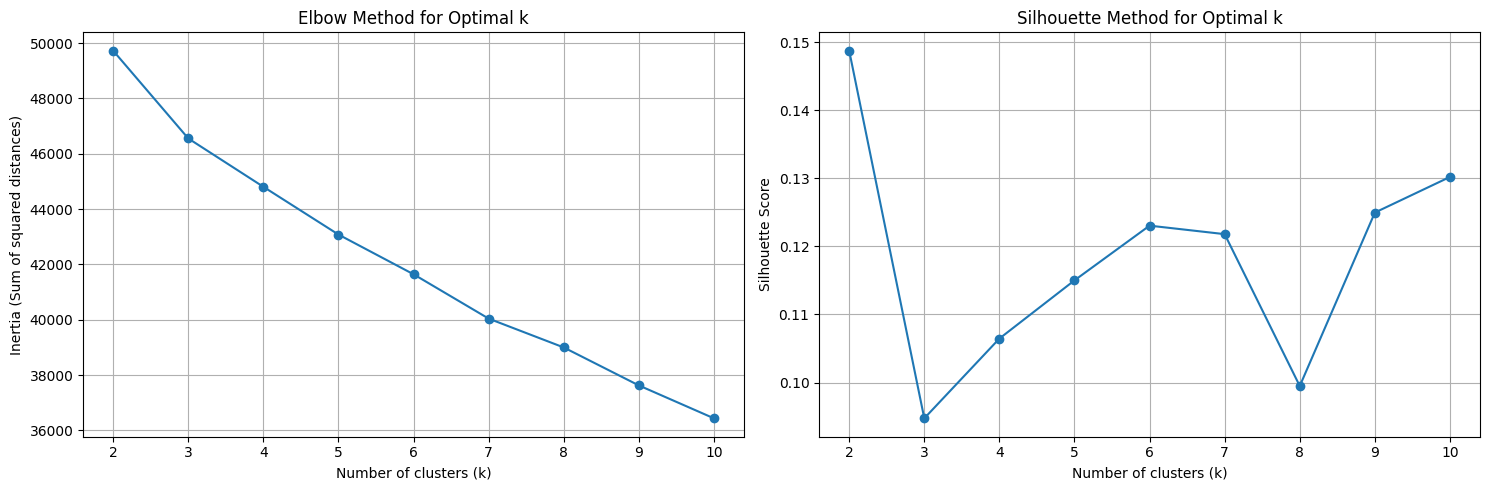

Optimal number of clusters: 2
Cluster 0: Card Game (Subcluster 0) games characterized by card game, language: high, physical components, family, difficulty: medium
Number of games: 55
Sample games: ['Illuminati', 'Blue vs. Gray', 'Catan Card Game', 'X Pasch', 'Magic: The Gathering']

Cluster 1: Card Game (Subcluster 1) games characterized by card game, difficulty: easy, language: none, duration: medium, kids
Number of games: 250
Sample games: ['Bohnanza', 'David & Goliath', 'Mamma Mia!', 'Lost Cities', 'Joan of Arc']

Cluster 2: Other games characterized by military conflict, duration: very long, language: medium, difficulty: medium, teen
Number of games: 811
Sample games: ['Die Macher', 'Acquire', 'El Caballero', 'CATAN', 'Cosmic Encounter']

Cluster 3: Other games characterized by language: none, kids, difficulty: easy, duration: medium, duration: short
Number of games: 487
Sample games: ['Samurai', 'Tal der Könige', 'Cathedral', 'Elfenland', 'Ra']



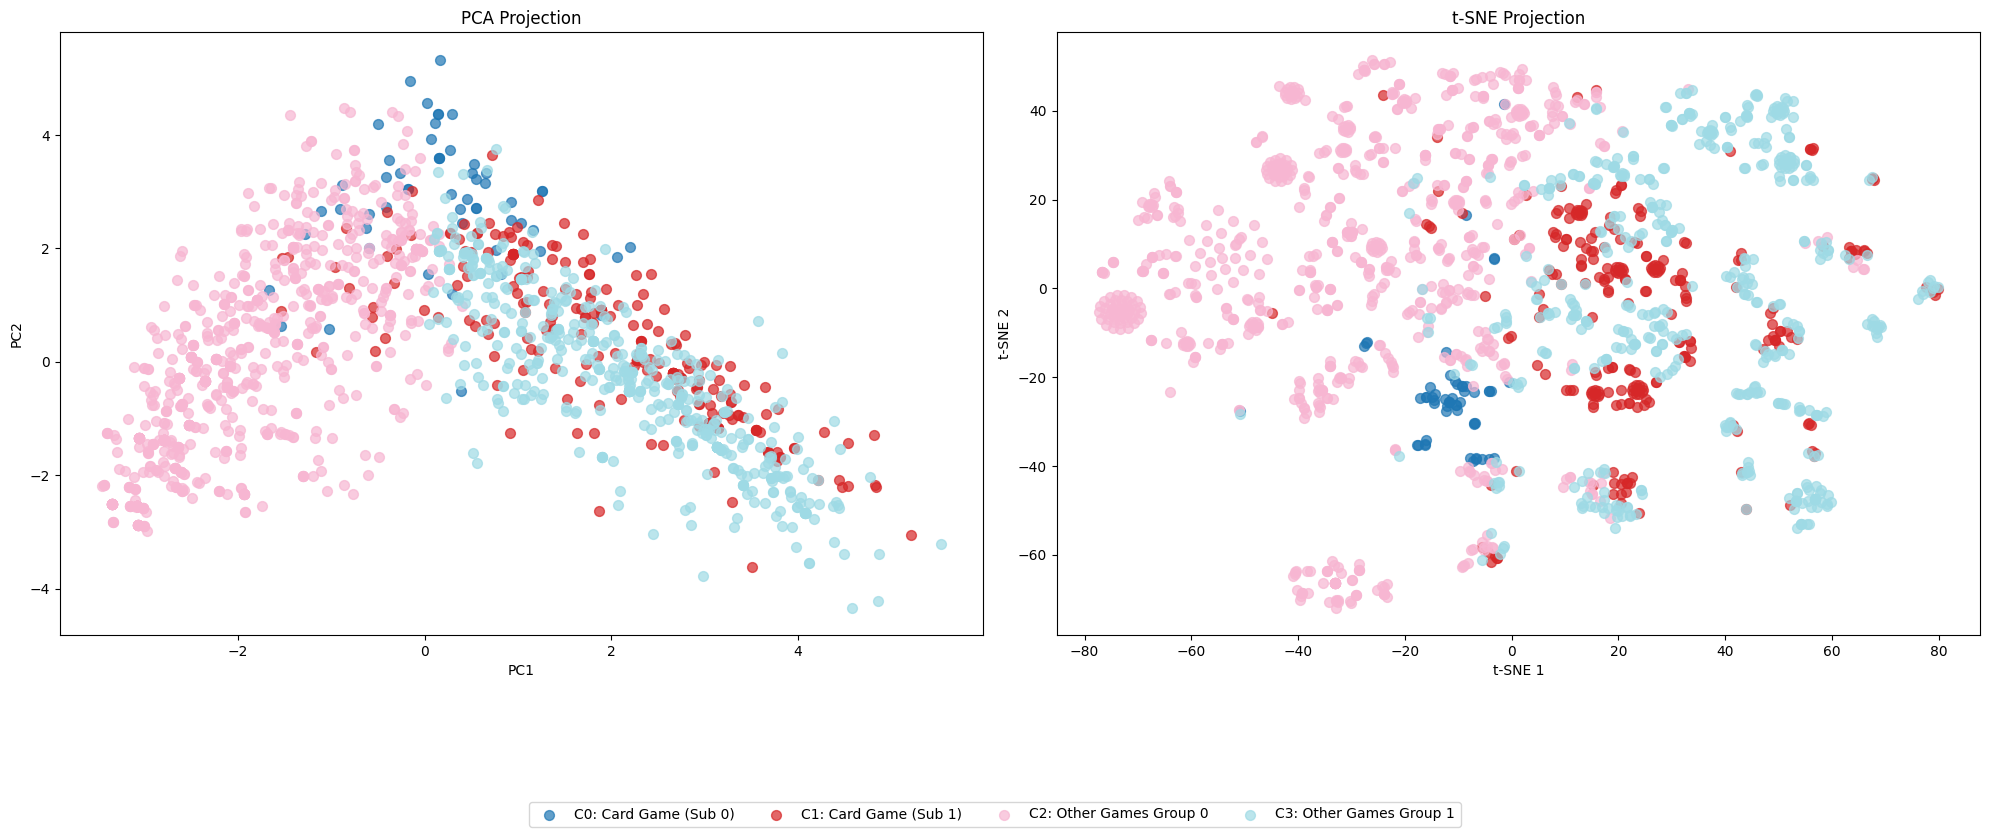

In [9]:
import polars as pl
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

feature_columns = [
    'AGE_GROUP_teen', 'AGE_GROUP_family', 'AGE_GROUP_adult', 'AGE_GROUP_kids', 
    'GAME_CAT_GROUP_time_period_historical', 'GAME_CAT_GROUP_military_conflict', 
    'GAME_CAT_GROUP_based_on_media', 'GAME_CAT_GROUP_crime_espionage', 
    'GAME_CAT_GROUP_fantasy_supernatural', 'GAME_CAT_GROUP_horror', 
    'GAME_CAT_GROUP_resource_management', 'GAME_CAT_GROUP_card_game', 
    'GAME_CAT_GROUP_physical_components', 'GAME_CAT_GROUP_print_and_play', 
    'GAME_CAT_GROUP_memory', 'GAME_CAT_GROUP_trivia', 'GAME_CAT_GROUP_deduction', 
    'GAME_CAT_GROUP_vehicles_movement', 'GAME_CAT_GROUP_negotiation', 
    'GAME_CAT_GROUP_mental_skill', 'GAME_CAT_GROUP_social_entertainment', 
    'GAME_CAT_GROUP_journey_discovery', 'GAME_CAT_GROUP_real_world_topics', 
    'GAME_CAT_GROUP_sports', 'GAME_CAT_GROUP_fighting', 'GAME_CAT_GROUP_abstract_strategy', 
    'GAME_CAT_GROUP_real_time', 'GAME_CAT_GROUP_action_dexterity', 
    'GAME_CAT_GROUP_game_system', 'GAME_CAT_GROUP_electronic', 
    'LANGUAGE_DEPENDENCY_high', 'LANGUAGE_DEPENDENCY_none', 'LANGUAGE_DEPENDENCY_extreme', 
    'LANGUAGE_DEPENDENCY_medium', 'LANGUAGE_DEPENDENCY_low', 'GAME_DURATION_very_long', 
    'GAME_DURATION_medium', 'GAME_DURATION_short', 'GAME_DURATION_long', 
    'GAME_DIFFICULTY_very hard', 'GAME_DIFFICULTY_very easy', 'GAME_DIFFICULTY_medium', 
    'GAME_DIFFICULTY_easy', 'GAME_DIFFICULTY_hard'
]

class ConstrainedBoardGameRecommender:
    def __init__(self):
        self.scaler = StandardScaler()
        self.games_df = None
        self.feature_data = None
        self.cluster_descriptions = None
        self.id_column = None
        self.name_column = None
        self.constraint_columns = []
        self.clusters = {}
        self.scaled_features = None
        
    def fit(self, games_df, constraint_columns, id_column=None, name_column=None, 
            subcluster_constrained=True, min_games_for_subclustering=20):
        """
        Fit the model with constrained clustering.
        
        Parameters:
        -----------
        games_df : polars.DataFrame
            DataFrame containing board game features
        constraint_columns : list
            List of column names that will be used to force clustering
            Example: ['GAME_CAT_GROUP_card_game', 'GAME_CAT_GROUP_abstract_strategy']
        id_column : str, optional
            Name of the column containing game IDs
        name_column : str, optional
            Name of the column containing game names
        subcluster_constrained : bool, default=True
            Whether to further cluster games within constraint groups
        min_games_for_subclustering : int, default=20
            Minimum number of games required to perform subclustering
        """
        self.games_df = games_df.clone()
        self.id_column = id_column
        self.name_column = name_column
        self.constraint_columns = constraint_columns
        
        # Extract feature data
        self.feature_data = games_df.select(feature_columns).to_numpy()
        
        # Scale the data for future similarity calculations
        self.scaler.fit(self.feature_data)
        self.scaled_features = self.scaler.transform(self.feature_data)
        
        # Create constrained clusters
        self._create_constrained_clusters(subcluster_constrained, min_games_for_subclustering)
        
        # Add cluster labels to the DataFrame
        self._add_cluster_labels()
        
        # Generate cluster descriptions
        self.generate_cluster_descriptions()
        
        return self

    def _find_optimal_k(self, data, max_k=10):
        """Find the optimal number of clusters using the elbow method"""
        if len(data) < 3:
            return 1
        
        max_k = min(max_k, len(data) - 1)
        if max_k < 2:
            return 1
            
        inertias = []
        silhouette_scores = []
        
        k_range = range(2, max_k + 1)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(data)
            inertias.append(kmeans.inertia_)
            
            # Only calculate silhouette if we have enough samples and more than one cluster
            if len(data) > k and k > 1:
                labels = kmeans.labels_
                silhouette_scores.append(silhouette_score(data, labels))
            else:
                silhouette_scores.append(0)
        
        # Calculate the rate of decrease of inertia
        inertia_diffs = np.diff(inertias)
        inertia_diffs = np.append(inertia_diffs, inertia_diffs[-1])
        inertia_ratios = inertia_diffs / inertias
        
        # Find the "elbow" where the ratio of improvement drops
        optimal_k = 2  # Default to 2 clusters
        if len(inertia_ratios) > 1:
            # Look for significant drops in improvement
            threshold = np.mean(inertia_ratios) * 0.5
            potential_elbows = np.where(inertia_ratios < threshold)[0]
            if len(potential_elbows) > 0:
                optimal_k = k_range[potential_elbows[0]]
            
            # Also consider silhouette scores
            best_silhouette_idx = np.argmax(silhouette_scores)
            silhouette_k = k_range[best_silhouette_idx]
            
            # Balance between inertia and silhouette
            if silhouette_scores[best_silhouette_idx] > 0.5:  # Strong cluster structure
                optimal_k = silhouette_k
            else:
                optimal_k = min(optimal_k, silhouette_k + 2)  # Compromise
        
        # Sanity check - don't create too many small clusters
        optimal_k = min(optimal_k, max(2, len(data) // 10))
        
        return optimal_k
    
    def visualize_elbow_method(self, data, max_k=10):
        """Visualize the elbow method to find optimal number of clusters"""
        max_k = min(max_k, len(data) - 1)
        if max_k < 2:
            plt.figure(figsize=(10, 5))
            plt.title("Not enough data for elbow method visualization")
            plt.show()
            return 1
            
        inertias = []
        silhouette_scores = []
        
        k_range = range(2, max_k + 1)
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(data)
            inertias.append(kmeans.inertia_)
            
            # Only calculate silhouette if we have enough samples
            if len(data) > k and k > 1:
                labels = kmeans.labels_
                silhouette_scores.append(silhouette_score(data, labels))
            else:
                silhouette_scores.append(0)
        
        # Plot the elbow curve
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Inertia plot (sum of squared distances)
        ax1.plot(k_range, inertias, 'o-')
        ax1.set_xlabel('Number of clusters (k)')
        ax1.set_ylabel('Inertia (Sum of squared distances)')
        ax1.set_title('Elbow Method for Optimal k')
        ax1.grid(True)
        
        # Silhouette plot
        ax2.plot(k_range, silhouette_scores, 'o-')
        ax2.set_xlabel('Number of clusters (k)')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Method for Optimal k')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Return the optimal k
        optimal_k = self._find_optimal_k(data, max_k)
        print(f"Optimal number of clusters: {optimal_k}")
        return optimal_k
    
    def _create_constrained_clusters(self, subcluster_constrained=True, min_games_for_subclustering=20):
        """Create clusters based on constraint columns, with optional subclustering within constraints"""
        self.clusters = {}
        cluster_id = 0
        
        # First, handle the explicitly constrained clusters
        for constraint in self.constraint_columns:
            if constraint not in self.games_df.columns:
                print(f"Warning: Constraint column '{constraint}' not found in the data")
                continue
                
            # Get games that match this constraint
            matching_games = self.games_df.filter(pl.col(constraint) == 1)
            
            if matching_games.height > 0:
                # Get the indices of matching games
                mask = (self.games_df[constraint] == 1).to_list()
                indices = [i for i, matches in enumerate(mask) if matches]
                
                if subcluster_constrained and len(indices) >= min_games_for_subclustering:
                    # Extract and scale features for this constraint group
                    constraint_features = self.feature_data[indices]
                    scaled_constraint_features = self.scaler.transform(constraint_features)
                    
                    # Find optimal k for this constrained group
                    print(f"Finding optimal subclusters for {constraint}...")
                    n_subclusters = self._find_optimal_k(scaled_constraint_features, 
                                                        max_k=min(10, len(indices)//5))
                    
                    # Apply K-means to create subclusters within this constraint
                    kmeans = KMeans(n_clusters=n_subclusters, random_state=42, n_init=10)
                    sub_labels = kmeans.fit_predict(scaled_constraint_features)
                    
                    # Create cluster entries for each subcluster
                    for sub_id in range(n_subclusters):
                        sub_indices = [indices[i] for i in range(len(indices)) 
                                      if sub_labels[i] == sub_id]
                        
                        if sub_indices:
                            subcluster_name = f"{constraint}_subcluster_{sub_id}"
                            self.clusters[cluster_id] = {
                                'constraint': subcluster_name,
                                'parent_constraint': constraint,
                                'indices': sub_indices,
                                'count': len(sub_indices),
                                'is_subcluster': True,
                                'subcluster_id': sub_id
                            }
                            cluster_id += 1
                else:
                    # Just create one cluster for this constraint
                    self.clusters[cluster_id] = {
                        'constraint': constraint,
                        'indices': indices,
                        'count': matching_games.height,
                        'is_subcluster': False
                    }
                    cluster_id += 1
        
        # Then create clusters for games that don't match any constraints
        assigned_indices = set()
        for cluster_info in self.clusters.values():
            assigned_indices.update(cluster_info['indices'])
        
        remaining_indices = list(set(range(self.games_df.height)) - assigned_indices)
        
        if remaining_indices:
            # For remaining games, use standard K-means to further segment them
            if len(remaining_indices) >= min_games_for_subclustering:
                # Extract features for unassigned games
                remaining_features = self.feature_data[remaining_indices]
                
                # Scale the features
                scaled_remaining_features = self.scaler.transform(remaining_features)
                
                # Find optimal number of clusters
                print("Finding optimal clusters for unconstrained games...")
                n_subclusters = self.visualize_elbow_method(
                    scaled_remaining_features, 
                    max_k=min(10, len(remaining_indices)//10)
                )
                
                # Apply K-means
                kmeans = KMeans(n_clusters=n_subclusters, random_state=42, n_init=10)
                sub_labels = kmeans.fit_predict(scaled_remaining_features)
                
                # Create clusters for each sub-group
                for sub_id in range(n_subclusters):
                    sub_indices = [remaining_indices[i] for i in range(len(remaining_indices)) 
                                 if sub_labels[i] == sub_id]
                    
                    if sub_indices:
                        self.clusters[cluster_id] = {
                            'constraint': 'other_games_group_' + str(sub_id),
                            'indices': sub_indices,
                            'count': len(sub_indices),
                            'is_subcluster': False
                        }
                        cluster_id += 1
            else:
                # If too few games, just create one "other" cluster
                self.clusters[cluster_id] = {
                    'constraint': 'other_games',
                    'indices': remaining_indices,
                    'count': len(remaining_indices),
                    'is_subcluster': False
                }
                cluster_id += 1
    
    def _add_cluster_labels(self):
        """Add cluster labels to the DataFrame"""
        # Initialize all cluster labels to -1
        cluster_labels = [-1] * self.games_df.height
        subcluster_labels = [-1] * self.games_df.height
        parent_constraint_labels = [""] * self.games_df.height
        
        # Assign cluster labels
        for cluster_id, cluster_info in self.clusters.items():
            for idx in cluster_info['indices']:
                cluster_labels[idx] = cluster_id
                
                # If this is a subcluster, store the subcluster ID and parent constraint
                if cluster_info.get('is_subcluster', False):
                    subcluster_labels[idx] = cluster_info.get('subcluster_id', -1)
                    parent_constraint_labels[idx] = cluster_info.get('parent_constraint', "")
        
        # Add to DataFrame
        self.games_df = self.games_df.with_columns([
            pl.Series("cluster", cluster_labels),
            pl.Series("subcluster", subcluster_labels),
            pl.Series("parent_constraint", parent_constraint_labels)
        ])
    
    def generate_cluster_descriptions(self):
        """Generate descriptions for each cluster based on feature importance"""
        self.cluster_descriptions = {}
        
        for cluster_id, cluster_info in self.clusters.items():
            # Get games in this cluster
            cluster_games = self.games_df.filter(pl.col("cluster") == cluster_id)
            
            if cluster_games.height == 0:
                continue
                
            # Calculate average feature values for this cluster
            cluster_means = {}
            for feature in feature_columns:
                cluster_means[feature] = cluster_games.select(pl.col(feature)).mean().item()
            
            # Find the most important features (highest average values)
            sorted_features = sorted(cluster_means.items(), key=lambda x: x[1], reverse=True)
            top_features = [feature for feature, _ in sorted_features[:5]]
            
            # Create a description
            constraint_name = cluster_info['constraint'].replace("GAME_CAT_GROUP_", "").replace("_", " ")
            
            if cluster_info.get('is_subcluster', False):
                parent_constraint = cluster_info.get('parent_constraint', '')
                parent_name = parent_constraint.replace("GAME_CAT_GROUP_", "").replace("_", " ")
                subcluster_id = cluster_info.get('subcluster_id', 0)
                
                description = f"Cluster {cluster_id}: {parent_name.title()} (Subcluster {subcluster_id}) games characterized by "
            elif any(constraint in cluster_info['constraint'] for constraint in self.constraint_columns):
                description = f"Cluster {cluster_id}: {constraint_name.title()} games characterized by "
            else:
                description = f"Cluster {cluster_id}: Other games characterized by "
                
            description += ", ".join([
                f.replace("GAME_CAT_GROUP_", "").replace("AGE_GROUP_", "")
                .replace("LANGUAGE_DEPENDENCY_", "language: ")
                .replace("GAME_DURATION_", "duration: ")
                .replace("GAME_DIFFICULTY_", "difficulty: ")
                .replace("_", " ") 
                for f in top_features
            ])
            
            # Get sample games
            if self.name_column:
                sample_games = cluster_games.select(pl.col(self.name_column)).to_series().to_list()[:5]
            elif self.id_column:
                sample_games = cluster_games.select(pl.col(self.id_column)).to_series().to_list()[:5]
            else:
                sample_games = [f"Game #{i}" for i in range(min(5, cluster_games.height))]
            
            self.cluster_descriptions[cluster_id] = {
                'description': description,
                'constraint': cluster_info['constraint'],
                'is_subcluster': cluster_info.get('is_subcluster', False),
                'parent_constraint': cluster_info.get('parent_constraint', ''),
                'top_features': top_features,
                'count': cluster_games.height,
                'sample_games': sample_games
            }
        
        return self.cluster_descriptions
    
    def visualize_clusters(self, method='pca', random_state=42):
        """
        Visualize clusters using dimensionality reduction
        
        Parameters:
        -----------
        method : str, default='pca'
            Method for dimensionality reduction, either 'pca' or 'tsne'
        random_state : int, default=42
            Random seed for reproducibility
        """
        # Scale the features if not already done
        if self.scaled_features is None:
            self.scaled_features = self.scaler.transform(self.feature_data)
        
        # Apply dimensionality reduction
        if method.lower() == 'tsne':
            reducer = TSNE(n_components=2, random_state=random_state, perplexity=min(30, len(self.scaled_features)//10))
            title_prefix = 'TSNE'
        else:  # Default to PCA
            reducer = PCA(n_components=2)
            title_prefix = 'PCA'
            
        reduced_features = reducer.fit_transform(self.scaled_features)
        
        # Get cluster labels
        cluster_labels = self.games_df.select("cluster").to_series().to_list()
        
        # Create a plot
        plt.figure(figsize=(14, 10))
        
        # Use a colormap that works well for many clusters
        colors = plt.cm.tab20(np.linspace(0, 1, len(self.clusters)))
        
        for i, (cluster_id, cluster_info) in enumerate(self.clusters.items()):
            # Get points for this cluster
            cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
            cluster_points = reduced_features[cluster_indices]
            
            if len(cluster_points) > 0:
                # Get constraint name for the legend
                constraint = cluster_info['constraint']
                
                if cluster_info.get('is_subcluster', False):
                    parent = cluster_info.get('parent_constraint', '').replace("GAME_CAT_GROUP_", "")
                    subcluster_id = cluster_info.get('subcluster_id', 0)
                    label = f'C{cluster_id}: {parent.replace("_", " ").title()} (Sub {subcluster_id})'
                else:
                    constraint_name = constraint.replace("GAME_CAT_GROUP_", "").replace("_", " ").title()
                    label = f'C{cluster_id}: {constraint_name}'
                
                plt.scatter(
                    cluster_points[:, 0], 
                    cluster_points[:, 1], 
                    label=label,
                    color=colors[i % len(colors)],
                    s=50,
                    alpha=0.7
                )
        
        plt.title(f'Board Game Clusters ({title_prefix} Visualization)')
        plt.xlabel(f'{title_prefix} Component 1')
        plt.ylabel(f'{title_prefix} Component 2')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    
    def visualize_both_projections(self, random_state=42):
        """
        Visualize clusters using both PCA and t-SNE for comparison
        """
        # Scale the features if not already done
        if self.scaled_features is None:
            self.scaled_features = self.scaler.transform(self.feature_data)

        # Apply PCA
        pca = PCA(n_components=2)
        pca_features = pca.fit_transform(self.scaled_features)
        
        # Apply t-SNE
        perplexity = min(30, max(5, self.scaled_features.shape[0] // 100))
        tsne = TSNE(n_components=2, random_state=random_state, perplexity=perplexity)
        tsne_features = tsne.fit_transform(self.scaled_features)
        
        # Get cluster labels
        cluster_labels = self.games_df.select("cluster").to_series().to_list()
        
        # Create a figure with two subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Use a colormap that works well for many clusters
        colors = plt.cm.tab20(np.linspace(0, 1, len(self.clusters)))
        
        # Plot PCA projection
        for i, (cluster_id, cluster_info) in enumerate(self.clusters.items()):
            # Get points for this cluster
            cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
            cluster_points = pca_features[cluster_indices]
            
            if len(cluster_points) > 0:
                # Format label based on cluster type
                if cluster_info.get('is_subcluster', False):
                    parent = cluster_info.get('parent_constraint', '').replace("GAME_CAT_GROUP_", "")
                    subcluster_id = cluster_info.get('subcluster_id', 0)
                    label = f'C{cluster_id}: {parent.replace("_", " ").title()} (Sub {subcluster_id})'
                else:
                    constraint = cluster_info['constraint']
                    constraint_name = constraint.replace("GAME_CAT_GROUP_", "").replace("_", " ").title()
                    label = f'C{cluster_id}: {constraint_name}'
                
                ax1.scatter(
                    cluster_points[:, 0], 
                    cluster_points[:, 1], 
                    label=label,
                    color=colors[i % len(colors)],
                    s=50,
                    alpha=0.7
                )
        
        ax1.set_title('PCA Projection')
        ax1.set_xlabel('PC1')
        ax1.set_ylabel('PC2')
        
        # Plot t-SNE projection
        for i, (cluster_id, cluster_info) in enumerate(self.clusters.items()):
            # Get points for this cluster
            cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster_id]
            cluster_points = tsne_features[cluster_indices]
            
            if len(cluster_points) > 0:
                # Format label based on cluster type
                if cluster_info.get('is_subcluster', False):
                    parent = cluster_info.get('parent_constraint', '').replace("GAME_CAT_GROUP_", "")
                    subcluster_id = cluster_info.get('subcluster_id', 0)
                    label = f'C{cluster_id}: {parent.replace("_", " ").title()} (Sub {subcluster_id})'
                else:
                    constraint = cluster_info['constraint']
                    constraint_name = constraint.replace("GAME_CAT_GROUP_", "").replace("_", " ").title()
                    label = f'C{cluster_id}: {constraint_name}'
                
                ax2.scatter(
                    cluster_points[:, 0], 
                    cluster_points[:, 1], 
                    label=label,
                    color=colors[i % len(colors)],
                    s=50,
                    alpha=0.7
                )
        
        ax2.set_title('t-SNE Projection')
        ax2.set_xlabel('t-SNE 1')
        ax2.set_ylabel('t-SNE 2')
        
        # Create a unified legend
        handles, labels = ax1.get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), 
                   ncol=min(5, len(handles)))
        
        plt.tight_layout()
        plt.subplots_adjust(bottom=0.2)
        plt.show()
    
    def get_cluster_info(self, cluster_id):
        """Get information about a specific cluster"""
        if cluster_id not in self.cluster_descriptions:
            return f"Cluster {cluster_id} not found"
        
        info = self.cluster_descriptions[cluster_id]
        return info
    
    def get_all_clusters_info(self):
        """Get information about all clusters"""
        return self.cluster_descriptions

# Example usage:
# Assuming you already have a Polars DataFrame called 'df'
recommender = ConstrainedBoardGameRecommender()

# Define constraint columns - games with these features will be forced into separate clusters
constraint_columns = ['GAME_CAT_GROUP_card_game']

# Fit the model with subclustering enabled for constrained groups
recommender.fit(
    df, 
    constraint_columns=constraint_columns,
    id_column="game_id", 
    name_column="game_name",
    subcluster_constrained=True
)

# Print cluster information
for cluster_id, info in recommender.get_all_clusters_info().items():
    print(info['description'])
    print(f"Number of games: {info['count']}")
    print(f"Sample games: {info['sample_games']}")
    print()

# Visualize clusters with both PCA and t-SNE
recommender.visualize_both_projections()

Finding optimal subclusters for GAME_CAT_GROUP_card_game...
Finding optimal clusters for unconstrained games...


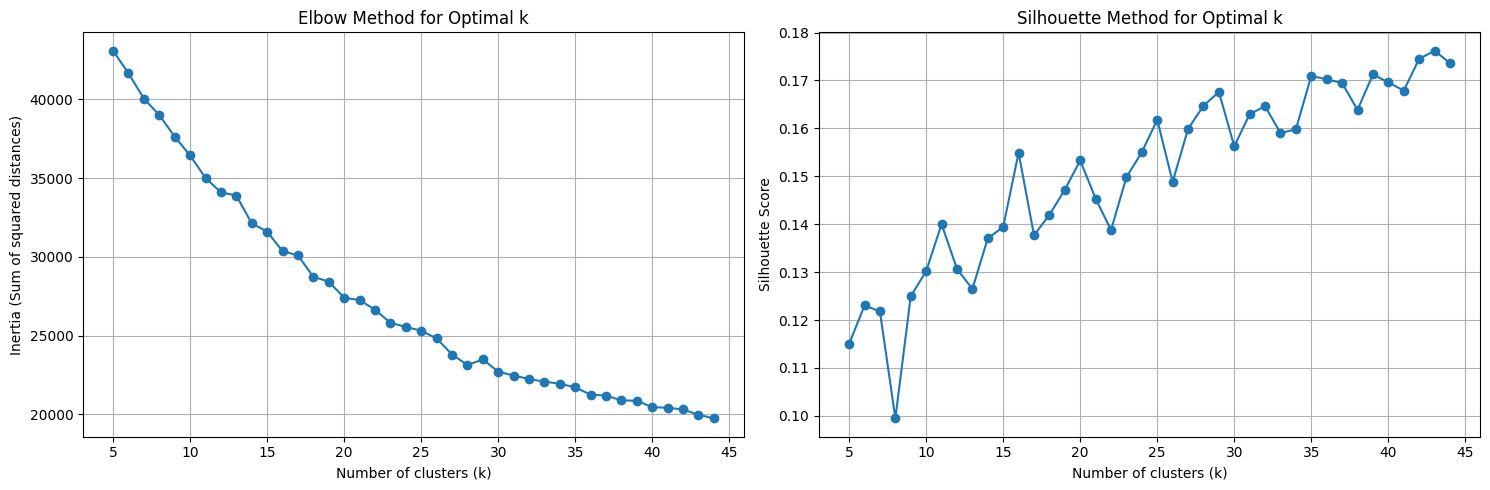

Optimal number of clusters: 5
Cluster 0: Card Game (Subcluster 0) games characterized by card game, language: high, physical components, family, difficulty: medium
Number of games: 55
Sample games: ['Illuminati', 'Blue vs. Gray', 'Catan Card Game', 'X Pasch', 'Magic: The Gathering']

Cluster 1: Card Game (Subcluster 1) games characterized by card game, difficulty: easy, language: none, duration: medium, kids
Number of games: 250
Sample games: ['Bohnanza', 'David & Goliath', 'Mamma Mia!', 'Lost Cities', 'Joan of Arc']

Cluster 2: Other games characterized by kids, difficulty: easy, language: none, duration: short, duration: medium
Number of games: 321
Sample games: ['Cathedral', 'Elfenland', 'Basari', 'Button Men', 'Wacky Wacky West']

Cluster 3: Other games characterized by family, difficulty: medium, duration: long, language: none, military conflict
Number of games: 442
Sample games: ['Samurai', 'Tal der Könige', 'Acquire', 'El Caballero', 'Ra']

Cluster 4: Other games characterized b

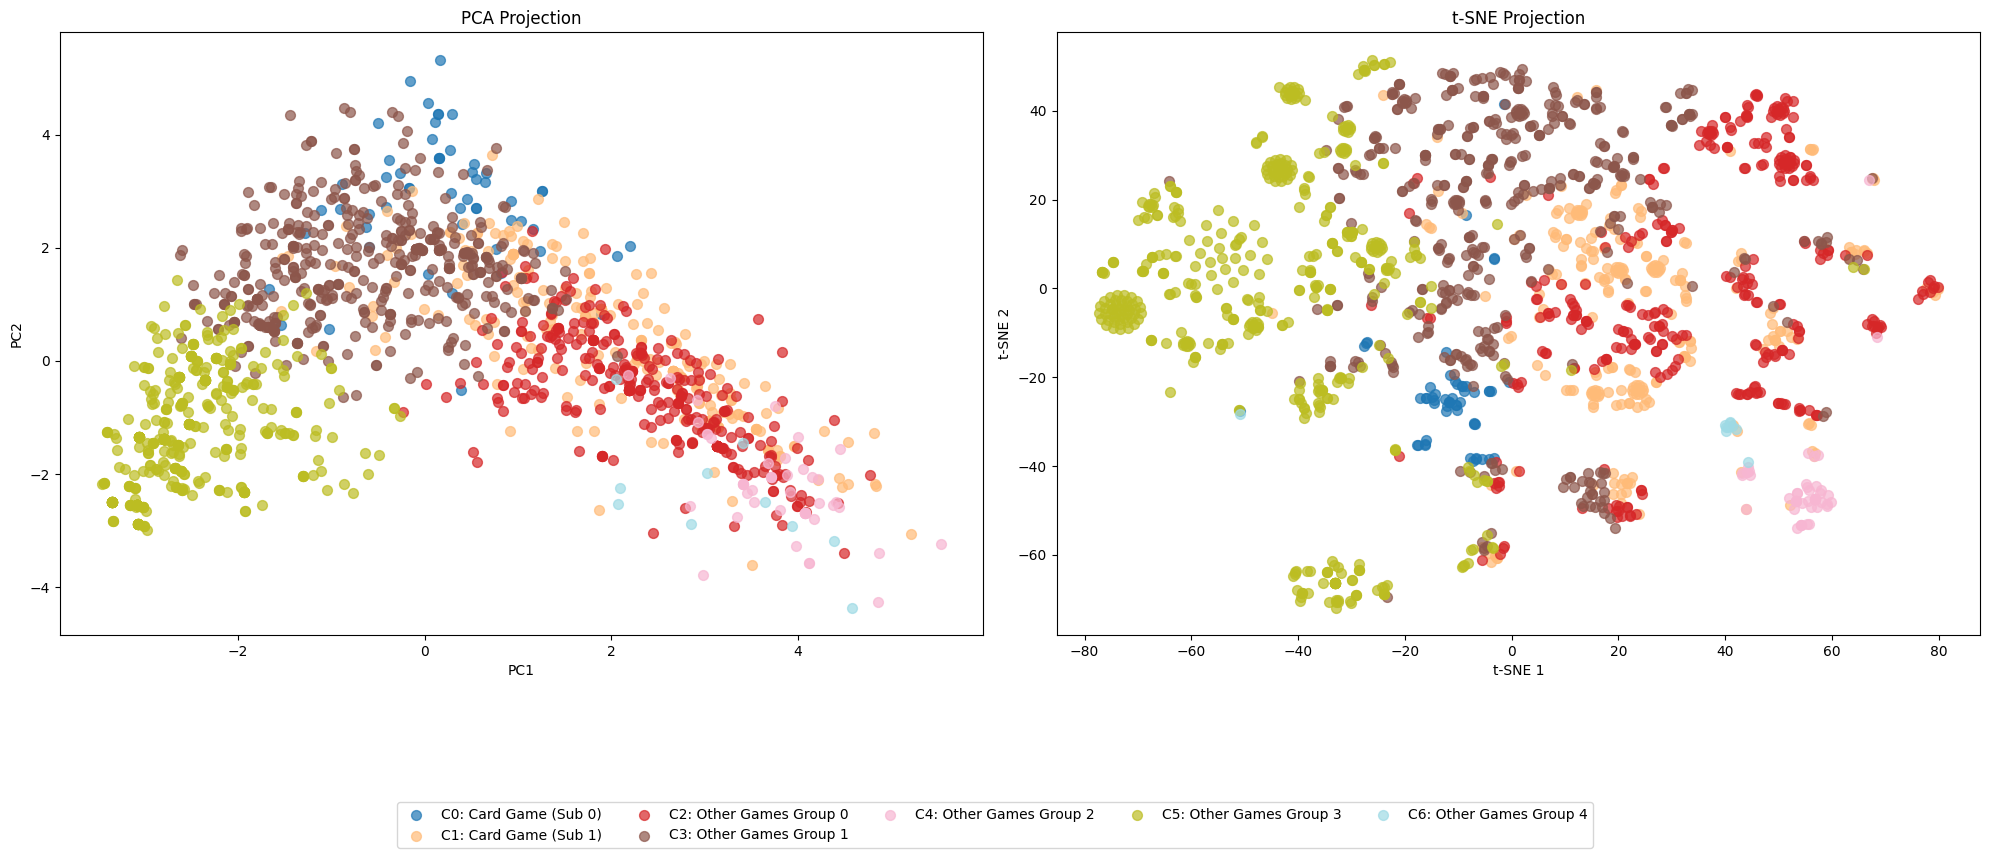

In [ ]:
import polars as pl
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

feature_columns = [
    'AGE_GROUP_teen', 'AGE_GROUP_family', 'AGE_GROUP_adult', 'AGE_GROUP_kids', 
    'GAME_CAT_GROUP_time_period_historical', 'GAME_CAT_GROUP_military_conflict', 
    'GAME_CAT_GROUP_based_on_media', 'GAME_CAT_GROUP_crime_espionage', 
    'GAME_CAT_GROUP_fantasy_supernatural', 'GAME_CAT_GROUP_horror', 
    'GAME_CAT_GROUP_resource_management', 'GAME_CAT_GROUP_card_game', 
    'GAME_CAT_GROUP_physical_components', 'GAME_CAT_GROUP_print_and_play', 
    'GAME_CAT_GROUP_memory', 'GAME_CAT_GROUP_trivia', 'GAME_CAT_GROUP_deduction', 
    'GAME_CAT_GROUP_vehicles_movement', 'GAME_CAT_GROUP_negotiation', 
    'GAME_CAT_GROUP_mental_skill', 'GAME_CAT_GROUP_social_entertainment', 
    'GAME_CAT_GROUP_journey_discovery', 'GAME_CAT_GROUP_real_world_topics', 
    'GAME_CAT_GROUP_sports', 'GAME_CAT_GROUP_fighting', 'GAME_CAT_GROUP_abstract_strategy', 
    'GAME_CAT_GROUP_real_time', 'GAME_CAT_GROUP_action_dexterity', 
    'GAME_CAT_GROUP_game_system', 'GAME_CAT_GROUP_electronic', 
    'LANGUAGE_DEPENDENCY_high', 'LANGUAGE_DEPENDENCY_none', 'LANGUAGE_DEPENDENCY_extreme', 
    'LANGUAGE_DEPENDENCY_medium', 'LANGUAGE_DEPENDENCY_low', 'GAME_DURATION_very_long', 
    'GAME_DURATION_medium', 'GAME_DURATION_short', 'GAME_DURATION_long', 
    'GAME_DIFFICULTY_very hard', 'GAME_DIFFICULTY_very easy', 'GAME_DIFFICULTY_medium', 
    'GAME_DIFFICULTY_easy', 'GAME_DIFFICULTY_hard'
]

class ConstrainedBoardGameRecommender:
    def __init__(self):
        self.scaler = StandardScaler()
        self.games_df = None
        self.feature_data = None
        self.cluster_descriptions = None
        self.id_column = None
        self.name_column = None
        self.constraint_columns = []
        self.clusters = {}
        self.scaled_features = None
        
    def fit(self, games_df, constraint_columns, id_column=None, name_column=None, 
            subcluster_constrained=True, min_games_for_subclustering=20):
        """
        Fit the model with constrained clustering.
        
        Parameters:
        -----------
        games_df : polars.DataFrame
            DataFrame containing board game features
        constraint_columns : list
            List of column names that will be used to force clustering
            Example: ['GAME_CAT_GROUP_card_game', 'GAME_CAT_GROUP_abstract_strategy']
        id_column : str, optional
            Name of the column containing game IDs
        name_column : str, optional
            Name of the column containing game names
        subcluster_constrained : bool, default=True
            Whether to further cluster games within constraint groups
        min_games_for_subclustering : int, default=20
            Minimum number of games required to perform subclustering
        """
        self.games_df = games_df.clone()
        self.id_column = id_column
        self.name_column = name_column
        self.constraint_columns = constraint_columns
        
        # Extract feature data
        self.feature_data = games_df.select(feature_columns).to_numpy()
        
        # Scale the data for future similarity calculations
        self.scaler.fit(self.feature_data)
        self.scaled_features = self.scaler.transform(self.feature_data)
        
        # Create constrained clusters
        self._create_constrained_clusters(subcluster_constrained, min_games_for_subclustering)
        
        # Add cluster labels to the DataFrame
        self._add_cluster_labels()
        
        # Generate cluster descriptions
        self.generate_cluster_descriptions()
        
        return self

    def _find_optimal_k(self, data, max_k=10, min_k=2, is_constraint=False):
        """Find the optimal number of clusters using multiple evaluation metrics with adaptive size constraints"""
        from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
        import numpy as np
        from collections import Counter

        # Calculate adaptive optimal range based on data size
        data_size = len(data)
        adaptive_min_k = max(2, int(np.log(data_size) / 2))
        adaptive_max_k = max(5, int(np.sqrt(data_size) / 4))

        # Set appropriate minimum k based on constraints and adaptive range
        if is_constraint:
            actual_min_k = max(min_k, adaptive_min_k - 1)  # Slightly more flexible for constraints
        else:
            actual_min_k = max(min_k, adaptive_min_k)

        # Handle edge cases with limited data
        if data_size < actual_min_k + 1:
            return max(2, data_size - 1) if is_constraint else max(1, data_size - 1)

        # Adjust max_k based on data dimensions and adaptive range
        feature_count = data.shape[1]
        max_k = min(max_k, feature_count, data_size - 1, adaptive_max_k * 2)  # Allow exploring up to 2x the adaptive max

        if max_k < actual_min_k:
            return max_k

        # Initialize storage for metrics
        k_range = range(actual_min_k, max_k + 1)
        silhouette_scores = []
        ch_scores = []          # Calinski-Harabasz Index
        db_scores = []          # Davies-Bouldin Index
        stability_scores = []   # Cluster stability across subsets
        cluster_size_scores = []  # New metric for cluster count appropriateness

        # Evaluate each k using multiple metrics
        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(data)

            # Calculate Silhouette score (higher is better)
            if data_size > k and k > 1:
                sil_score = silhouette_score(data, labels)
                silhouette_scores.append(sil_score)
            else:
                silhouette_scores.append(0)

            # Calculate Calinski-Harabasz Index (higher is better)
            if k > 1:
                ch_score = calinski_harabasz_score(data, labels)
                ch_scores.append(ch_score)
            else:
                ch_scores.append(0)

            # Calculate Davies-Bouldin Index (lower is better)
            if k > 1:
                db_score = davies_bouldin_score(data, labels)
                db_scores.append(db_score)
            else:
                db_scores.append(float('inf'))

            # Stability analysis using subsampling
            if data_size > 30:  # Only if we have enough samples
                stability_sum = 0
                n_trials = 3

                for _ in range(n_trials):
                    # Random subsampling (80% of data)
                    indices = np.random.choice(data_size, size=int(0.8 * data_size), replace=False)
                    subsample = data[indices]

                    # Train on subsample
                    sub_kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                    sub_kmeans.fit(subsample)

                    # Measure agreement with full model
                    agreement = 0
                    for i, idx in enumerate(indices):
                        # For each point, check if nearest centroid is the same in both models
                        full_nearest = np.argmin([np.linalg.norm(data[idx] - c) for c in kmeans.cluster_centers_])
                        sub_nearest = np.argmin([np.linalg.norm(subsample[i] - c) for c in sub_kmeans.cluster_centers_])
                        if full_nearest == sub_nearest:
                            agreement += 1

                    stability_sum += agreement / len(indices)

                stability_scores.append(stability_sum / n_trials)
            else:
                stability_scores.append(0)

            # Calculate cluster size appropriateness score
            if adaptive_min_k <= k <= adaptive_max_k:
                # Full score within the optimal range
                cluster_size_scores.append(1.0)
            else:
                # Gradually decreasing score outside optimal range
                distance = min(abs(k - adaptive_min_k), abs(k - adaptive_max_k))
                max_reasonable = int(np.sqrt(data_size) / 2)  # Upper limit for reasonable clusters
                score = max(0, 1.0 - (distance / max(1, max_reasonable)))
                cluster_size_scores.append(score)

        # Normalize scores to [0, 1] range for fair comparison
        def normalize(scores, higher_is_better=True):
            if all(s == scores[0] for s in scores):
                return [1] * len(scores) if higher_is_better else [0] * len(scores)
            min_val, max_val = min(scores), max(scores)
            if min_val == max_val:
                return [0.5] * len(scores)
            normalized = [(s - min_val) / (max_val - min_val) for s in scores]
            if not higher_is_better:
                normalized = [1 - n for n in normalized]
            return normalized

        norm_silhouette = normalize(silhouette_scores)
        norm_ch = normalize(ch_scores)
        norm_db = normalize(db_scores, higher_is_better=False)
        norm_stability = normalize(stability_scores)
        norm_cluster_size = cluster_size_scores  # Already normalized

        # Weighted voting - combine all metrics
        # Adjust weights based on importance for recommendation system
        weights = {
            'silhouette': 0.30,    # Good for finding well-separated clusters
            'ch': 0.20,            # Good for dense, well-separated clusters
            'db': 0.10,            # Good for identifying distinct clusters
            'stability': 0.20,     # Good for finding robust clusters
            'cluster_size': 0.20   # Weight for appropriate cluster count
        }

        final_scores = []
        for i in range(len(k_range)):
            score = (
                weights['silhouette'] * norm_silhouette[i] +
                weights['ch'] * norm_ch[i] +
                weights['db'] * norm_db[i] +
                weights['stability'] * norm_stability[i] +
                weights['cluster_size'] * norm_cluster_size[i]
            )
            final_scores.append(score)

        # Smooth the scores to reduce noise
        window_size = min(3, len(final_scores))
        smoothed_scores = np.convolve(final_scores, np.ones(window_size)/window_size, mode='valid')

        # Find the optimal k
        if len(smoothed_scores) > 0:
            best_idx = np.argmax(smoothed_scores)
            optimal_k = k_range[best_idx:best_idx+1][0]
        else:
            # Fallback to the k with best silhouette score
            optimal_k = k_range[np.argmax(silhouette_scores)]

        return optimal_k
    
    def _create_constrained_clusters(self, subcluster_constrained=True, min_games_for_subclustering=20):
        """Create clusters based on constraint columns, with optional subclustering within constraints"""
        self.clusters = {}
        cluster_id = 0
        
        # First, handle the explicitly constrained clusters
        for constraint in self.constraint_columns:
            if constraint not in self.games_df.columns:
                print(f"Warning: Constraint column '{constraint}' not found in the data")
                continue
                
            # Get games that match this constraint
            matching_games = self.games_df.filter(pl.col(constraint) == 1)
            
            if matching_games.height > 0:
                # Get the indices of matching games
                mask = (self.games_df[constraint] == 1).to_list()
                indices = [i for i, matches in enumerate(mask) if matches]
                
                if subcluster_constrained and len(indices) >= min_games_for_subclustering:
                    # Extract and scale features for this constraint group
                    constraint_features = self.feature_data[indices]
                    scaled_constraint_features = self.scaler.transform(constraint_features)
                    
                    # Find optimal k for this constrained group (min 2 clusters for constraints)
                    print(f"Finding optimal subclusters for {constraint}...")
                    n_subclusters = self._find_optimal_k(
                        scaled_constraint_features, 
                        max_k=min(10, len(indices)//5),
                        min_k=2,
                        is_constraint=True
                    )
                    
                    # Apply K-means to create subclusters within this constraint
                    kmeans = KMeans(n_clusters=n_subclusters, random_state=42, n_init=10)
                    sub_labels = kmeans.fit_predict(scaled_constraint_features)
                    
                    # Create cluster entries for each subcluster
                    for sub_id in range(n_subclusters):
                        sub_indices = [indices[i] for i in range(len(indices)) 
                                      if sub_labels[i] == sub_id]
                        
                        if sub_indices:
                            subcluster_name = f"{constraint}_subcluster_{sub_id}"
                            self.clusters[cluster_id] = {
                                'constraint': subcluster_name,
                                'parent_constraint': constraint,
                                'indices': sub_indices,
                                'count': len(sub_indices),
                                'is_subcluster': True,
                                'subcluster_id': sub_id
                            }
                            cluster_id += 1
                else:
                    # Just create one cluster for this constraint
                    self.clusters[cluster_id] = {
                        'constraint': constraint,
                        'indices': indices,
                        'count': matching_games.height,
                        'is_subcluster': False
                    }
                    cluster_id += 1
        
        # Then create clusters for games that don't match any constraints
        assigned_indices = set()
        for cluster_info in self.clusters.values():
            assigned_indices.update(cluster_info['indices'])
        
        remaining_indices = list(set(range(self.games_df.height)) - assigned_indices)
        
        if remaining_indices:
            # For remaining games, use standard K-means to further segment them
            if len(remaining_indices) >= min_games_for_subclustering:
                # Extract features for unassigned games
                remaining_features = self.feature_data[remaining_indices]
                
                # Scale the features
                scaled_remaining_features = self.scaler.transform(remaining_features)
                
                # Find optimal number of clusters (min 5 clusters for non-constraints)
                print("Finding optimal clusters for unconstrained games...")
                n_subclusters = self.visualize_elbow_method(
                    scaled_remaining_features, 
                    max_k=min(len(feature_columns), len(remaining_indices)//10),
                    min_k=5,
                    is_constraint=False
                )
                
                # Apply K-means
                kmeans = KMeans(n_clusters=n_subclusters, random_state=42, n_init=10)
                sub_labels = kmeans.fit_predict(scaled_remaining_features)
                
                # Create clusters for each sub-group
                for sub_id in range(n_subclusters):
                    sub_indices = [remaining_indices[i] for i in range(len(remaining_indices)) 
                                 if sub_labels[i] == sub_id]
                    
                    if sub_indices:
                        self.clusters[cluster_id] = {
                            'constraint': 'other_games_group_' + str(sub_id),
                            'indices': sub_indices,
                            'count': len(sub_indices),
                            'is_subcluster': False
                        }
                        cluster_id += 1
            else:
                # If too few games, just create one "other" cluster
                self.clusters[cluster_id] = {
                    'constraint': 'other_games',
                    'indices': remaining_indices,
                    'count': len(remaining_indices),
                    'is_subcluster': False
                }
                cluster_id += 1
    
    def _add_cluster_labels(self):
        """Add cluster labels to the DataFrame"""
        # Initialize all cluster labels to -1
        cluster_labels = [-1] * self.games_df.height
        subcluster_labels = [-1] * self.games_df.height
        parent_constraint_labels = [""] * self.games_df.height
        
        # Assign cluster labels
        for cluster_id, cluster_info in self.clusters.items():
            for idx in cluster_info['indices']:
                cluster_labels[idx] = cluster_id
                
                # If this is a subcluster, store the subcluster ID and parent constraint
                if cluster_info.get('is_subcluster', False):
                    subcluster_labels[idx] = cluster_info.get('subcluster_id', -1)
                    parent_constraint_labels[idx] = cluster_info.get('parent_constraint', "")
        
        # Add to DataFrame
        self.games_df = self.games_df.with_columns([
            pl.Series("cluster", cluster_labels),
            pl.Series("subcluster", subcluster_labels),
            pl.Series("parent_constraint", parent_constraint_labels)
        ])
    
    def generate_cluster_descriptions(self):
        """Generate descriptions for each cluster based on feature importance"""
        self.cluster_descriptions = {}
        
        for cluster_id, cluster_info in self.clusters.items():
            # Get games in this cluster
            cluster_games = self.games_df.filter(pl.col("cluster") == cluster_id)
            
            if cluster_games.height == 0:
                continue
                
            # Calculate average feature values for this cluster
            cluster_means = {}
            for feature in feature_columns:
                cluster_means[feature] = cluster_games.select(pl.col(feature)).mean().item()
            
            # Find the most important features (highest average values)
            sorted_features = sorted(cluster_means.items(), key=lambda x: x[1], reverse=True)
            top_features = [feature for feature, _ in sorted_features[:5]]
            
            # Create a description
            constraint_name = cluster_info['constraint'].replace("GAME_CAT_GROUP_", "").replace("_", " ")
            
            if cluster_info.get('is_subcluster', False):
                parent_constraint = cluster_info.get('parent_constraint', '')
                parent_name = parent_constraint.replace("GAME_CAT_GROUP_", "").replace("_", " ")
                subcluster_id = cluster_info.get('subcluster_id', 0)
                
                description = f"Cluster {cluster_id}: {parent_name.title()} (Subcluster {subcluster_id}) games characterized by "
            elif any(constraint in cluster_info['constraint'] for constraint in self.constraint_columns):
                description = f"Cluster {cluster_id}: {constraint_name.title()} games characterized by "
            else:
                description = f"Cluster {cluster_id}: Other games characterized by "
                
            description += ", ".join([
                f.replace("GAME_CAT_GROUP_", "").replace("AGE_GROUP_", "")
                .replace("LANGUAGE_DEPENDENCY_", "language: ")
                .replace("GAME_DURATION_", "duration: ")
                .replace("GAME_DIFFICULTY_", "difficulty: ")
                .replace("_", " ") 
                for f in top_features
            ])
            
            # Get sample games
            if self.name_column:
                sample_games = cluster_games.select(pl.col(self.name_column)).to_series().to_list()[:5]
            elif self.id_column:
                sample_games = cluster_games.select(pl.col(self.id_column)).to_series().to_list()[:5]
            else:
                sample_games = [f"Game #{i}" for i in range(min(5, cluster_games.height))]
            
            self.cluster_descriptions[cluster_id] = {
                'description': description,
                'constraint': cluster_info['constraint'],
                'is_subcluster': cluster_info.get('is_subcluster', False),
                'parent_constraint': cluster_info.get('parent_constraint', ''),
                'top_features': top_features,
                'count': cluster_games.height,
                'sample_games': sample_games
            }
        
        return self.cluster_descriptions
    
    def get_cluster_info(self, cluster_id):
        """Get information about a specific cluster"""
        if cluster_id not in self.cluster_descriptions:
            return f"Cluster {cluster_id} not found"
        
        info = self.cluster_descriptions[cluster_id]
        return info
    
    def get_all_clusters_info(self):
        """Get information about all clusters"""
        return self.cluster_descriptions

# Example usage:
recommender = ConstrainedBoardGameRecommender()

# Define constraint columns - games with these features will be forced into separate clusters
constraint_columns = ['GAME_CAT_GROUP_card_game']

# Fit the model with subclustering enabled for constrained groups
recommender.fit(
    df, 
    constraint_columns=constraint_columns,
    id_column="game_id", 
    name_column="game_name",
    subcluster_constrained=True
)

# Print cluster information
for cluster_id, info in recommender.get_all_clusters_info().items():
    print(info['description'])
    print(f"Number of games: {info['count']}")
    print(f"Sample games: {info['sample_games']}")
    print()

# Visualize clusters with both PCA and t-SNE
recommender.visualize_both_projections()